In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from evaluation import plot_key_figures, calc_key_figures
from optimization import *

# %matplotlib widget

C:\Users\jakob\AppData\Local\Temp\ipykernel_1820\1447030521.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load prices and plot

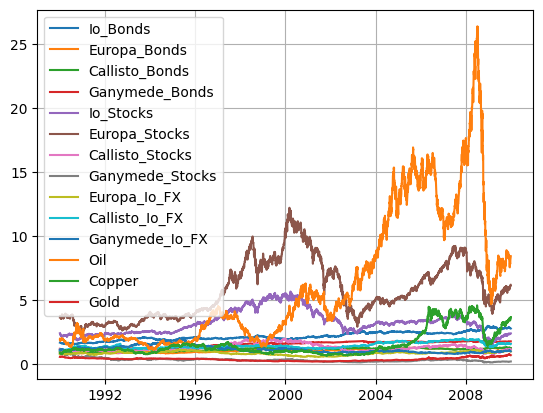

In [2]:
prices = pd.read_csv('prices_train.csv',index_col='AsOfDate',parse_dates=True)

plt.figure()
plt.plot(prices)
plt.legend(prices.columns)
plt.grid()

# Modeling example
The following notebook is a detailed modeling example that goes into further detail on how to analyze returns and use their autocorrelation to build a trading strategy.

## Load prices and plot

## Compute returns and normalized returns, using a rolling volatility (standard deviation) estimate
Normalization is typically done before analysis, in order to get the different assets on the same scale, and simoultanously reduce the heteroscedasticity (volatility clusters) in the time series.

In [3]:
ret = prices.diff()

#### Volatility estimates
We usually want a rolling estimate of volatility, that can adapt when the risks are changing and therefore reduce heteroscedasticity in the data. Using a sliding window of $N$ days, one can estimate/predict the volatility at day $t+1$ as $\hat{\sigma}_{t+1} = \sqrt{\frac{1}{N} \sum_{k=t-N}^{k=t}{r_t^2}}$. 

Notice that we don't adjust for the mean in this estimate, which is typically done when estimating standard deviation. We skip this since we assume that $E[r_t] \approx 0$ for daily returns, and the average on a short time frame might be a worse estimate of the mean than simply using zero. There are many other ways to estimate volatility, for example using an ARCH or GARCH model.

In this case we are using a sliding window of 100 days, which is easy to compute using pandas. Notice that the estimates are shifted 1 day since the rolling window up to day $t$ is used to predict the volatility att day $t+1$.

Positions can be scaled by the volatility estimates in order to achieve the normalized returns when trading.

### Study the effect of normalization
By estimating the volatility over the whole time series, we see that all normalized return series now have about unit volatility, although it seems like we slightly tend to underestimate, since all instruments got realized volatilities greater than one.

In [4]:
#print(norm_ret.std())


#### Plot the normalized returns in the same figure as the raw returns, here for a single instrument. 
We see that we manage to adjust for heteroscedasticity, i.e that the volatility seem more constant over time.

In [5]:
#plt.figure()
#ret.iloc[:,0].plot()
#norm_ret.iloc[:,0].plot()
#plt.grid()
#plt.legend(['Raw returns','Normalized returns'])

## Research example: Estimate autocorrelations for varied block sizes of accumulated returns
In order to find any pattern between past and future returns, on various time horizons, we can estimate the correlation between lagged returns accumulated into consecutive blocks, i.e: $corr(b_{n-1},b_n)$, where $b = \big\{\sum_{t=0}^K{r_t}, \sum_{t=K}^{2K}{r_t}, ...,  \sum_{t=T-K}^{T}{r_t}\big\}$, where $K$ refers to the block size.

In [6]:
'''def calc_block_ac(ret, max_block_size):
    # Estimates correlation between consecutive blocks of returns (autocorrelation at lag 1), with block sizes 1, ..., max_block_size. 
    # We make use of the fact that blocks of N days can be constructed in N different ways (shifted to each other) 
    # to achieve the maximum sample size.
    
    block_days = range(1,max_block_size+1)
    acs=[]
    ret_nonan = ret.dropna()
    norm_p = ret_nonan.cumsum()
    
    # loop over all block sizes
    for n_days in block_days:
        shift_days = range(1,n_days+1)
        acs_shift=pd.DataFrame(np.nan,index=ret.columns,columns=shift_days)
        
        # loop over all possible shifts (ways of constructing the blocks)
        for n_shift in shift_days:
            p_shift = norm_p.shift(n_shift)
            # Construct blocks of n_days return (difference of cumulative sum of returns with n_days sampling frequency)
            ret_block = p_shift.iloc[::n_days].diff()
            # Correlation between consecutive blocks
            acs_shift[n_shift] = ret_block.corrwith(ret_block.shift(1))
        
        # Mean over all different shifts
        acs.append(acs_shift.mean(axis=1))
    autocorrs = pd.concat(acs,axis=1,keys=list(block_days)).T
    return autocorrs'''

'def calc_block_ac(ret, max_block_size):\n    # Estimates correlation between consecutive blocks of returns (autocorrelation at lag 1), with block sizes 1, ..., max_block_size. \n    # We make use of the fact that blocks of N days can be constructed in N different ways (shifted to each other) \n    # to achieve the maximum sample size.\n    \n    block_days = range(1,max_block_size+1)\n    acs=[]\n    ret_nonan = ret.dropna()\n    norm_p = ret_nonan.cumsum()\n    \n    # loop over all block sizes\n    for n_days in block_days:\n        shift_days = range(1,n_days+1)\n        acs_shift=pd.DataFrame(np.nan,index=ret.columns,columns=shift_days)\n        \n        # loop over all possible shifts (ways of constructing the blocks)\n        for n_shift in shift_days:\n            p_shift = norm_p.shift(n_shift)\n            # Construct blocks of n_days return (difference of cumulative sum of returns with n_days sampling frequency)\n            ret_block = p_shift.iloc[::n_days].diff()\n      

In [7]:
'''max_block = 50
autocorrs = calc_block_ac(norm_ret,max_block)'''

'max_block = 50\nautocorrs = calc_block_ac(norm_ret,max_block)'

### Plot the estimated autocorrelations
The autocorrelations seem positive for larger block sizes, but is it significant?

In [8]:
'''plt.figure()
plt.plot(autocorrs.mean(axis=1),'r',linewidth=2)
plt.grid()
plt.ylabel('Autocorrelation')
plt.xlabel('Block size')'''

"plt.figure()\nplt.plot(autocorrs.mean(axis=1),'r',linewidth=2)\nplt.grid()\nplt.ylabel('Autocorrelation')\nplt.xlabel('Block size')"

### Estimate standard deviation for autocorrelation estimates on shuffled returns (true autocorrelation=0)
Takes about 30s to compute. Use this to test the significance of the autocorrelation estimates on returns with correct order.

In [9]:
'''%%time
max_block = 50
rand_samples = 50

np.random.seed(1)

# Construct dataframe of max_block samples of shuffled returns
ret_shuffled_list = []
for k in range(rand_samples):
    r = norm_ret.sample(frac=1).set_index(norm_ret.index)
    ret_shuffled_list.append(r)
ret_shuffled=pd.concat(tuple(ret_shuffled_list),axis=1,keys=range(rand_samples))

# Compute auto correlation estimates for shuffled returns (true autocorrelation is zero, since shuffled)
ac_shuffled = calc_block_ac(ret_shuffled, max_block)

# Standard deviations for the estimates, for each block size
std_shuffled = ac_shuffled.groupby(axis=1,level=0).mean().std(axis=1)'''

'%%time\nmax_block = 50\nrand_samples = 50\n\nnp.random.seed(1)\n\n# Construct dataframe of max_block samples of shuffled returns\nret_shuffled_list = []\nfor k in range(rand_samples):\n    r = norm_ret.sample(frac=1).set_index(norm_ret.index)\n    ret_shuffled_list.append(r)\nret_shuffled=pd.concat(tuple(ret_shuffled_list),axis=1,keys=range(rand_samples))\n\n# Compute auto correlation estimates for shuffled returns (true autocorrelation is zero, since shuffled)\nac_shuffled = calc_block_ac(ret_shuffled, max_block)\n\n# Standard deviations for the estimates, for each block size\nstd_shuffled = ac_shuffled.groupby(axis=1,level=0).mean().std(axis=1)'

### Plot the estimated autocorrelations and $\pm 2$ standard deviations of the estimates on shuffled returns, i.e ~5% confidence interval

In [10]:
'''plt.figure()
plt.fill_between(ac_shuffled.index,2*std_shuffled,-2*std_shuffled)
plt.plot(autocorrs.mean(axis=1),'r',linewidth=2)
plt.grid()
plt.legend(['+-2 stdev for zero autocorrelation','Mean autocorrelation for returns'])
plt.ylabel('Autocorrelation')
plt.xlabel('Block size')'''

"plt.figure()\nplt.fill_between(ac_shuffled.index,2*std_shuffled,-2*std_shuffled)\nplt.plot(autocorrs.mean(axis=1),'r',linewidth=2)\nplt.grid()\nplt.legend(['+-2 stdev for zero autocorrelation','Mean autocorrelation for returns'])\nplt.ylabel('Autocorrelation')\nplt.xlabel('Block size')"

### Comment
The autocorrelation estimates seem significant for block sizes larger than ~20. This indicates that it should be a good idea to follow trends, i.e to take a positive position (go long) when the instrument returns have been positive on a period of sufficient length, and vise versa go short when the returns have been negative.

### Other hints for studying the data
What do the return distributions look like? What about the correlations between different assets?

## Trend model
Use the sign of returns accumulated on block sizes of 50 days as trading signal, and risk adjust by volatility estimates (as in the normalization above). 
Make sure that you only use information up to time $t-1$ for determining the position at time $t$! This is very important since the different markets close at different hours, and otherwise you might have forward looking bias, i.e using future information that was not yet available when determining the positions historically.

In [11]:
def trend_model(prices, trend_window=50, vol_window=100):
    ret = prices.ffill().diff()
    
    pos = pd.DataFrame(np.nan, index=ret.index, columns=ret.columns)

    FIRST_TRADING_DAY = 100
    lamb = 1
    delta = 0.0002
    x_tm1 = 0
    # loop over all dates
    for t in range(FIRST_TRADING_DAY, ret.shape[0]-1):
        ### predict here k time steps ahead of t. NEED TO IMPLEMENT!
        pricesHISTORY = prices.iloc[0:200,:]
        pricesPRED = prices.iloc[200:210,:]
        #print(pricesHISTORY.shape)
        #print(pricesPRED.shape)
        price_p_pred = pd.concat([pricesHISTORY, pricesPRED])
        #print(price_p_pred.shape)
        
        x_t = optimize(price_p_pred, x_tm1, lamb, delta, t)
        
        # Position at date t; risk adjust with volatility from previous date
        x_tm1 = x_t
        pos.iloc[t] = x_t
    return pos

#### Optionally, the same positions can be computed in this vectorized fashion (faster to compute):
Rolling functionality in pandas is usually safe to use if the positions are shifted as a last step

In [12]:
def trend_model_vectorized(ret, trend_window=50, vol_window=100):
    vol = np.sqrt((ret**2).rolling(window=vol_window).sum())
    pos_next_day = 1/vol*np.sign(ret.rolling(window=trend_window).sum())
    pos = pos_next_day.shift(1)
    return pos

In [13]:
pos = trend_model(ret)

(140, 140)
(2940, 2940)
(2940,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 140 is different from 2940)

### Comment
The positions does not necessarily have to be binary, real valued positions are allowed. In practice the positions would be integers (number of contracts), but with alot of capital to invest, the implied rounding errors can be neglected.


## Model returns & Evaluation

If positions are indexed correctly they should now be aligned with the days where the trades will be executed, i.e positions $pos_t$ will be traded during day $t$,
and generate a return between day $t$ and $t+1$. Since our dataframe with returns are aligned according to $r_t=p_t-p_{t-1}$, we need to shift our positions once more to calculate the model returns at time $t$, i.e the models return from yesterday until today is: $R_t = \sum_{k=1}^M{pos^m_{t-1}r^m_t}$

In [ ]:
model_ret = (pos.shift(1)*ret).sum(axis=1)

#### Plot the cumulative returns, to see how the model is performing over time

Text(0.5, 1.0, 'Cumulative returns excluding costs')

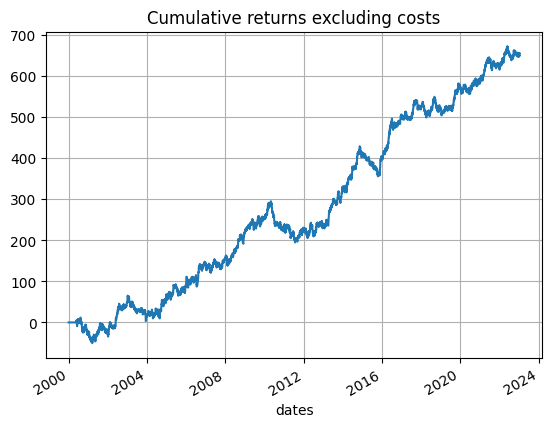

In [ ]:
plt.figure()
model_ret.cumsum().plot()
plt.grid()
plt.title('Cumulative returns excluding costs')

#### Evaluation with transaction costs and other key figures
The trading (position changes) will induce transaction costs, epecially when trading large volumes that will have an impact on the markets. These transaction costs are often called slippage. We will provide an evaluation tool for computing returns with approximated slippage, as well as some keyfigures that can be good to take into account. See the documentation in evaluation.py for more information about the key figures.

As a general guideline to the plotted key figures, generally hedge funds tend to prefer models with high sharpe ratios that are stable over time and that are insensitive to trading costs in the form of slippage or lagged positions. Furthermore, we prefer that returns are thin-tailed (with low kurtosis), positively skewed, and that the market exposure is low (here measured by the position-bias).

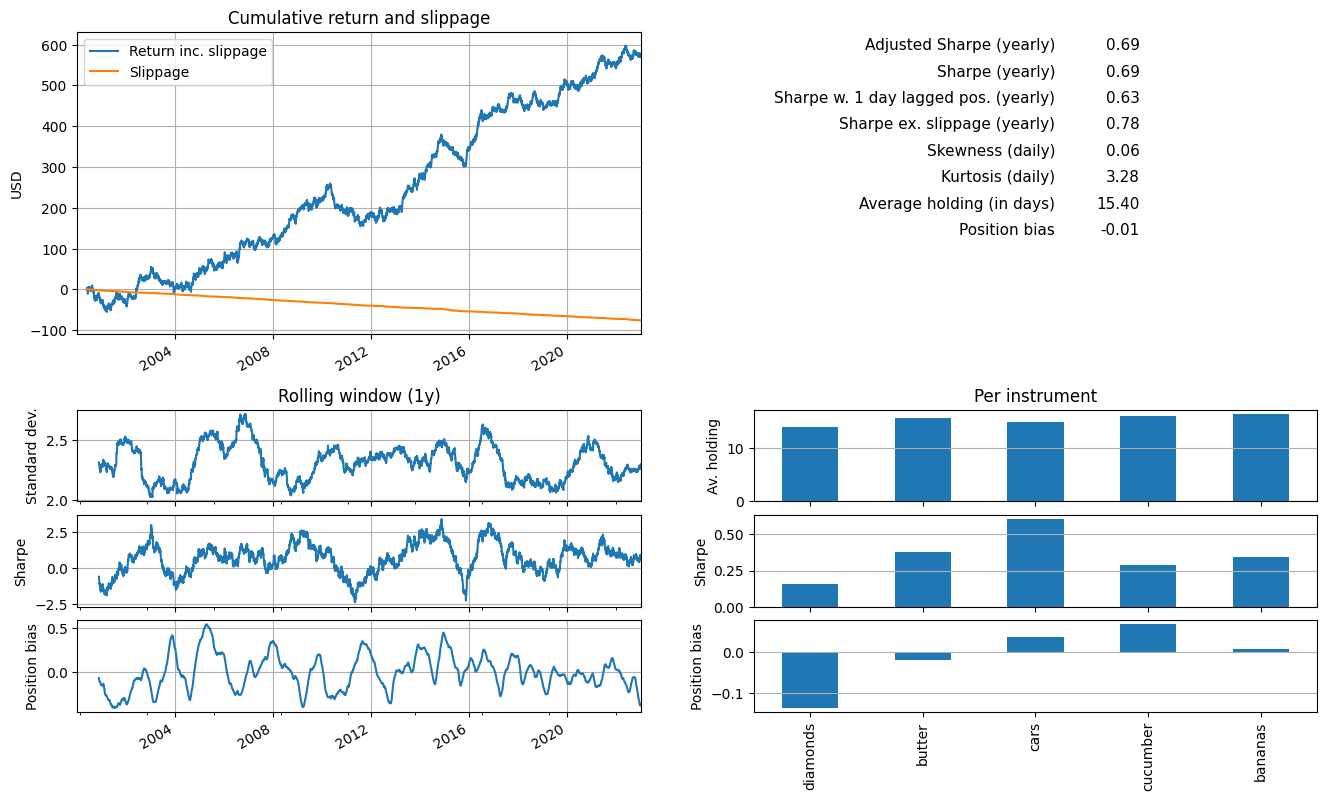

In [ ]:
plot_key_figures(pos, prices)

The evaluation tool can also return a dict containing estimated key figures, either small recommended subset or a user defined set of key figures.


In [ ]:
calc_key_figures(pos, prices)

{'sharpe': 0.6886308814861598,
 'sharpe_1d_lag': 0.6271356554361893,
 'av_holding': 15.396560820605533,
 'position_bias': -0.00933954640730842,
 'skewness': 0.05755619727385829,
 'kurtosis': 3.2791082307216155,
 'adjusted_sharpe': 0.6893821574094051}

Using this function we can, for example, investigate how model performance will change with different cost assumptions:

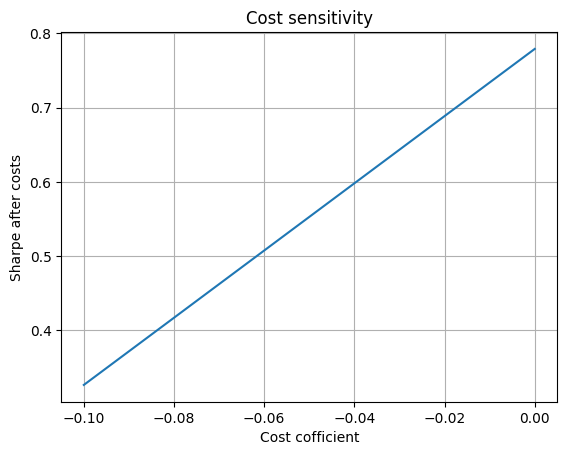

In [ ]:
cost_coeffs = np.linspace(0, -0.1, 10)

sharpe_per_cost_coef = [calc_key_figures(pos, prices, costs=cost_coef, key_figures=['sharpe'])['sharpe'] for cost_coef in cost_coeffs]

plt.figure()
plt.plot(cost_coeffs, sharpe_per_cost_coef)
plt.title('Cost sensitivity')
plt.ylabel('Sharpe after costs')
plt.xlabel('Cost cofficient')
plt.grid()

## Test for forward looking bias
A useful way to test for forward looking bias, besides not lagging positions correctly, is to generate positions using a shorter history of data, and make sure that the positions are identical to those obtained when using the whole dataset.

In [ ]:
pos = trend_model(ret)
pos_short = trend_model(ret.iloc[:-20])
(pos-pos_short).abs().sum()

diamonds    0.0
butter      0.0
cars        0.0
cucumber    0.0
bananas     0.0
dtype: float64